## 0. Load Data

In [1]:
dataname = 'yeast'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
df = pd.read_csv('../datasets/OD/%s/meta_data/%s.original.csv'%(dataname, dataname))
gt = pd.read_csv('../datasets/OD/%s/meta_data/%s.diff.csv'%(dataname, dataname))['ground.truth']
gt_idx = gt.index.values[gt == 'anomaly']

In [3]:
df.head()

,Y,M,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7
0,MIT,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,MIT,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,MIT,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,NUC,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,MIT,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


In [4]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [5]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [6]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.008405923843383789] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'None', 'NaN', 'unknown', '?', 'none', 'nan'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "Y": "text",
    "M": "text",
    "V": "numeric",
    "V.1": "numeric",
    "V.2": "numeric",
    "V.3": "numeric",
    "V.4": "numeric",
    "V.5": "numeric",
    "V.6": "numeric",
    "V.7": "numeric"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'Y': ['equal'], 'M': ['equal'], 'V': ['equal'], 'V.1': ['equal'], 'V.2': ['equal'], 'V.3': ['equal'], 'V.4': ['equal'], 'V.5': ['equal'], 'V.6': ['equal'], 'V.7': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_tha

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [7]:

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [8]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [9]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.05152416229248047] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 32 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 32, and the bound is 0.00014964
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 10/10 [00:00<00:00, 177.09it/s]
INFO:profiler.data.transformer:Number of training samples: 59360
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[0.25392818450927734] Create Training Data execution time: 0.20240402221679688



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [10]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[0.25916624069213867] Learn Structure start

INFO:profiler.learner:use threshold 0.0696
INFO:profiler.utility:[0.3962430953979492] Learn Structure execution time: 0.13707685470581055



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [11]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[0.40372204780578613] Get Dependencies start

INFO:profiler.utility:[0.4441251754760742] Get Dependencies execution time: 0.040403127670288086



V.1,Y -> M (0.002444586762958698)
M -> V (0.09846137661028914)
M -> V.2 (0.11418997454801419)
M -> V.3 (0.10428477519685854)
V.1,Y,M -> V.5 (0.017626981238019757)
M -> V.6 (0.13108764364577266)
M -> V.7 (0.22917225524730456)
V.1,Y,M,V.3 -> V.4 (0.016571477505562624)


## 5. Visualization

In [12]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

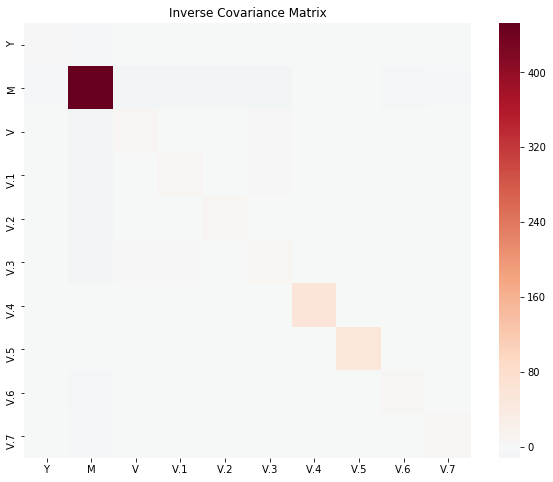

In [13]:
pf.session.visualize_inverse_covariance()

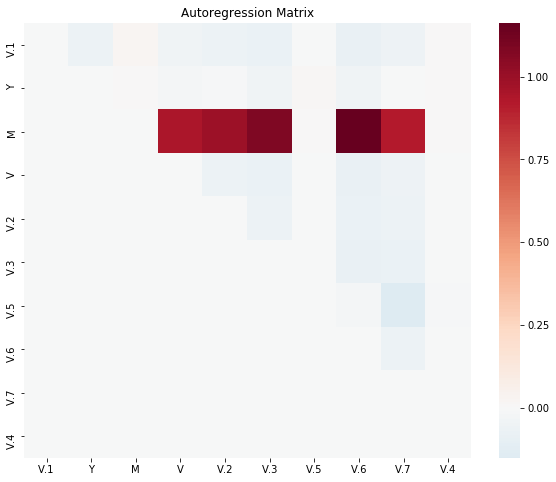

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.008406,start: Load Data,0.000000
1,0.027111,end: Load Data,0.018705
2,0.051524,start: Create Training Data,0.000000
3,0.253928,end: Create Training Data,0.202404
4,0.259166,start: Learn Structure,0.000000
5,0.396243,end: Learn Structure,0.137077
6,0.403722,start: Get Dependencies,0.000000
7,0.444125,end: Get Dependencies,0.040403
8,0.444125,total_execution_time,0.398589


In [16]:
from profiler.app.od import *

In [27]:
detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="ocsvm", gt_idx=gt_idx,
                           nu=0.1, gamma='auto', tol=1e-6, t=1e-6)
detector.run_all(parent_sets)
detector.evaluate()

INFO:profiler.utility:[0.0012958049774169922] naive start

INFO:profiler.utility:[1.6068828105926514] naive execution time: 1.6055870056152344

INFO:profiler.utility:[1.6076006889343262] structured start

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
INFO:profiler.utility:[7.283954858779907] structured execution time: 5.676354169845581



   time_point                   msg  execution_time
0    0.001296          start: naive        0.000000
1    1.606883            end: naive        1.605587
2    1.607601     start: structured        0.000000
3    7.283955       end: structured        5.676354
4    7.283955  total_execution_time        7.281941
Results for naive approach:
with 1484 detected outliers, precision is: 0.3416
with 1484 detected outliers, recall is: 1.0000
f1: 0.5093
Results for structure only:
with 1484 detected outliers, precision is: 0.3416
with 1484 detected outliers, recall is: 1.0000
f1: 0.5093
Results for enhance naive with structured:
with 1484 detected outliers, precision is: 0.3416
with 1484 detected outliers, recall is: 1.0000
f1: 0.5093


In [28]:
detector.structured_info

{'M': {'determined_by': array(['V.1', 'Y'], dtype=object),
  'num_neighbors': array([0., 0., 0., ..., 0., 0., 0.]),
  'num_outliers': array([0., 0., 0., ..., 0., 0., 0.]),
  'avg_neighbors': 0.0,
  'total_outliers': 0},
 'V': {'determined_by': array(['M'], dtype=object),
  'num_neighbors': array([1., 1., 1., ..., 1., 1., 1.]),
  'num_outliers': array([1., 1., 1., ..., 1., 1., 1.]),
  'avg_neighbors': 1.0296495956873315,
  'total_outliers': 1484},
 'V.2': {'determined_by': array(['M'], dtype=object),
  'num_neighbors': array([1., 1., 1., ..., 1., 1., 1.]),
  'num_outliers': array([1., 1., 1., ..., 1., 1., 1.]),
  'avg_neighbors': 1.0296495956873315,
  'total_outliers': 1484},
 'V.3': {'determined_by': array(['M'], dtype=object),
  'num_neighbors': array([1., 1., 1., ..., 1., 1., 1.]),
  'num_outliers': array([1., 1., 1., ..., 1., 1., 1.]),
  'avg_neighbors': 1.0296495956873315,
  'total_outliers': 1484},
 'V.5': {'determined_by': array(['V.1', 'Y', 'M'], dtype=object),
  'num_neighbors'

In [29]:
detector.overall_info

{'Y': {'avg_neighbors': 1484, 'total_outliers': 86},
 'M': {'avg_neighbors': 1484, 'total_outliers': 1484},
 'V': {'avg_neighbors': 1484, 'total_outliers': 141},
 'V.1': {'avg_neighbors': 1484, 'total_outliers': 133},
 'V.2': {'avg_neighbors': 1484, 'total_outliers': 142},
 'V.3': {'avg_neighbors': 1484, 'total_outliers': 138},
 'V.4': {'avg_neighbors': 1484, 'total_outliers': 1484},
 'V.5': {'avg_neighbors': 1484, 'total_outliers': 1484},
 'V.6': {'avg_neighbors': 1484, 'total_outliers': 124},
 'V.7': {'avg_neighbors': 1484, 'total_outliers': 884}}

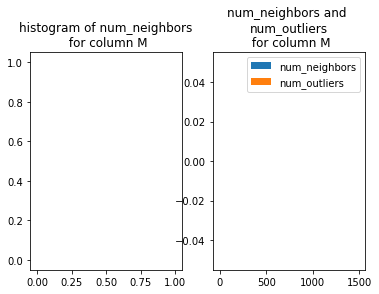

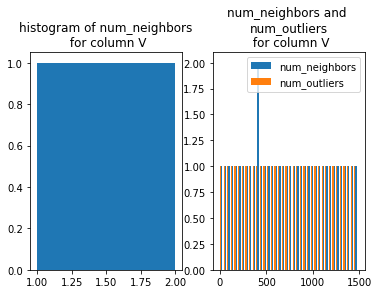

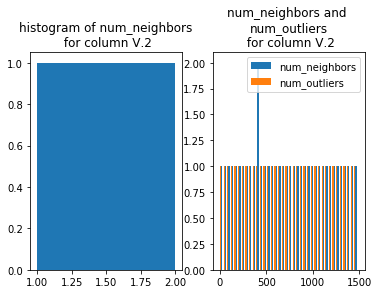

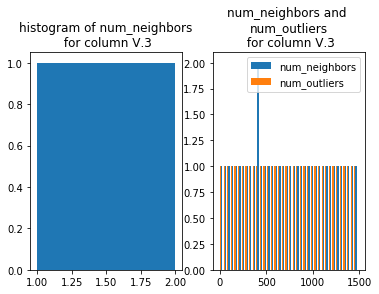

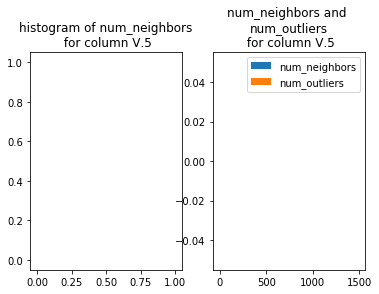

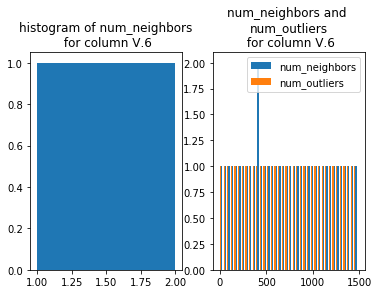

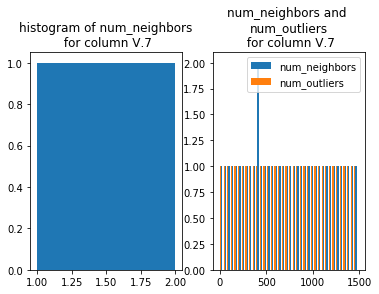

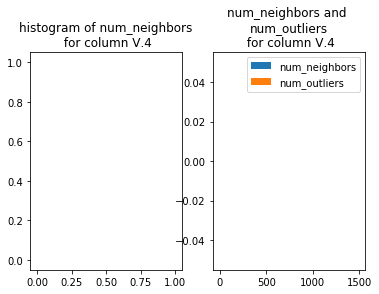

In [69]:
import matplotlib
import matplotlib.pyplot as plt
self = detector
for right in self.structured_info:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    data = self.structured_info[right]['num_neighbors']
    ax1.hist(data, density=True, bins=np.arange(data.min(), data.max()+1))
    ax1.set_title("histogram of num_neighbors\n for column %s"%right)
    width = 0.35 
    rects1 = ax2.bar(np.arange(len(data)),self.structured_info[right]['num_neighbors'],width)
    rects2 = ax2.bar(np.arange(len(data))+width,self.structured_info[right]['num_outliers'],width)
    ax2.legend((rects1[0], rects2[0]),['num_neighbors', 'num_outliers'])
    ax2.set_title("num_neighbors and \nnum_outliers\n for column %s"%right)